In [2]:
import cv2
import numpy as np

# Create a black image
img = np.zeros((512,512,3), np.uint8)

# Define two points with non-integer coordinates
pt1 = np.float32([100.5, 200.7])
pt2 = np.float32([300.9, 400.3])

# Draw a red line between the two points
cv2.line(img, tuple(pt1), tuple(pt2), (0,0,255), thickness=2)

# Display the image
cv2.imshow('image', img)
cv2.waitKey(0)
cv2.destroyAllWindows()


error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'line'
> Overload resolution failed:
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type


In [10]:
# Project 3 
# Submission By: Shantanu Parab (sparab), Vineet Singh (vsingh03)

# GITHUB Link: https://github.com/shantanuparabumd/ASTAR.git

# Imports
import math
import numpy as np
import time
from queue import PriorityQueue
import cv2
import argparse
import matplotlib.pyplot as plt

# Creating Node Class
class Astar:
    def __init__(self,width,height,scale,start,goal,robot_clear,obj_clear,step_size):
        
        # Get the video dimensions and FPS
        self.result = cv2.VideoWriter("Astar01.avi", cv2.VideoWriter_fourcc(*'MJPG'), 600, (width, height))
        
        # Define constants
        self.START=start
        self.GOAL=goal
        self.SCALE=scale
        self.WIDTH=width
        self.HEIGHT=height
        self.L=step_size
        self.frame_info=[]
        self.ROBOT=robot_clear
        self.OBJ=obj_clear

        # Define Colors
        self.background=(255,255,255)
        self.obst_color=(0,0,0)
        self.clear_color= (12, 253, 240)
        self.grid_color=(233, 226, 230, 0.2)
        self.start_color=(132, 222, 15, 0.8)
        self.goal_color=(254, 0, 0, 0.8)
        self.explored_color= (64, 188, 237)
        self.track_color= (16, 141, 16)
        self.robot_color= (62, 169, 119)
        self.robot_clear_color= (255, 254, 255)

        # Define Grid Size
        self.grid_size=2

        self.H_PX=self.WIDTH*self.SCALE/self.grid_size
        self.V_PX=self.HEIGHT*self.SCALE/self.grid_size

        self.HEX=self.hexagon(125,300,50)
        self.HEX_CLR=self.hexagon(125,300,50+(self.OBJ))
        self.HEX_ROBO_CLR=self.hexagon(125,300,50+(self.OBJ+self.ROBOT))
        # Triangle
        p1=(25-self.OBJ, 460-self.OBJ)
        p2=(25-self.OBJ, 460+self.OBJ)
        p3=(125,510+self.OBJ)
        p4=(225+self.OBJ, 460+self.OBJ)
        p5=(225+self.OBJ,460-self.OBJ)
        self.TRI_CLR = [p1, p2, p3, p4, p5]
        
        p1=(25-(self.OBJ+self.ROBOT), 460-(self.OBJ+self.ROBOT))
        p2=(25-(self.OBJ+self.ROBOT), 460+(self.OBJ+self.ROBOT))
        p3=(125,510+(self.OBJ+self.ROBOT))
        p4=(225+(self.OBJ+self.ROBOT), 460+(self.OBJ+self.ROBOT))
        p5=(225+(self.OBJ+self.ROBOT),460-(self.OBJ+self.ROBOT))
        self.TRI_ROBO_CLR = [p1, p2, p3, p4, p5]
        
        p1=(25,460)
        p2=(225, 460)
        p3=(125,510)
        self.TRI=[p1,p2,p3]
    
    def line_equation(self,p,p1,p2):
        try:
            m=(p2[1]-p1[1])/(p2[0]-p1[0])
            value=p[1]-p1[1]-(m*p[0])+(m*p1[0])
        except:
            value=p[0]-p1[0]
            
        return value
    
    def hexagon(self,cx, cy, sl):
            # Calculate the points of the hexagon
            center_x = cx
            center_y = cy
            side_length = sl
            angle_deg = 60
            angle_rad = math.radians(angle_deg)
            angle_deg = 60
            angle_rad = math.radians(angle_deg)
            points = []
            for i in range(6):
                x = round(center_x + side_length * math.cos(angle_rad * i))
                y = round(center_y + side_length * math.sin(angle_rad * i))
                points.append((x, y))
            return points
    
    def obstacle_detect_triangle(self,p,v1,v2,v3):
        h1=self.line_equation(p,v2,v3)>=0 if self.line_equation(v1,v2,v3)>0 else self.line_equation(p,v2,v3)<=0
        h2=self.line_equation(p,v1,v3)>=0 if self.line_equation(v2,v1,v3)>0 else self.line_equation(p,v1,v3)<=0
        h3=self.line_equation(p,v1,v2)>=0 if self.line_equation(v3,v1,v2)>0 else self.line_equation(p,v1,v2)<=0
        print(h1,h2,h3)
        return h1 and h2 and h3

    def obstacle_detect_rectangle(self,point,x,y,width,height):
        if point[0]>=x and point[1]>=y and point[0]<=(x+width) and point[1]<=(y+height):
            return True
        else:
            return False
    
    def obstacle_detect_boundary(self,point,x,y,width,height):
        if point[0]<=x or point[1]<=y or point[0]>=(x+width) or point[1]>=(y+height):
            return True
        else:
            return False
        
    def obstacle_detect_polygon(self,p,points):
        points=points+points[:3]
        for i in range(len(points)-3):
            v1,v2,v3=points[i],points[i+1],points[i+2]
            h=self.line_equation(p,v1,v2)>=0 if self.line_equation(v3,v1,v2)>0 else self.line_equation(p,v1,v2)<=0
            if not h:
                return False
        return True
        
    def check_obstacle(self,p):
        h1=self.obstacle_detect_rectangle(p,0,100,100,50)
        h2=self.obstacle_detect_rectangle(p,150,100,100,50)
        h3=self.obstacle_detect_polygon(p,self.HEX)
        h4=self.obstacle_detect_polygon(p,self.TRI)

        return (h1 or h2 or h3 or h4 )
    
    def check_clearance(self,p):
        h1=self.obstacle_detect_rectangle(p,0,100-self.OBJ,100+self.OBJ,50+2*self.OBJ)
        h2=self.obstacle_detect_rectangle(p,150-self.OBJ,100-self.OBJ,100+self.OBJ,50+2*self.OBJ)
        h3=self.obstacle_detect_polygon(p,self.HEX_CLR)
        h4=self.obstacle_detect_polygon(p,self.TRI_CLR)
        h5= self.obstacle_detect_boundary(p,self.OBJ,self.OBJ,250-2*self.OBJ,600-2*self.OBJ)
        
        return (h1 or h2 or h3 or h4 or h5)
    
    def check_robot(self,p):
        h1=self.obstacle_detect_rectangle(p,0,100-(self.OBJ+self.ROBOT),100+(self.OBJ+self.ROBOT),50+2*(self.OBJ+self.ROBOT))
        h2=self.obstacle_detect_rectangle(p,150-(self.OBJ+self.ROBOT),100-(self.OBJ+self.ROBOT),100+(self.OBJ+self.ROBOT),50+2*(self.OBJ+self.ROBOT))
        h3=self.obstacle_detect_polygon(p,self.HEX_ROBO_CLR)
        h4=self.obstacle_detect_polygon(p,self.TRI_ROBO_CLR)
        h5= self.obstacle_detect_boundary(p,(self.OBJ+self.ROBOT),(self.OBJ+self.ROBOT),250-2*(self.OBJ+self.ROBOT),600-2*(self.OBJ+self.ROBOT))
        
        return (h1 or h2 or h3 or h4 or h5)

    def make_obstacle_space(self):
        fig, axis = plt.subplots()
        grid=np.ones((self.HEIGHT,self.WIDTH,3),np.uint8)
        for i in range(self.HEIGHT):
            for j in  range(self.WIDTH):
                    if self.check_robot((i,j)):
                        grid[i][j]=np.array(self.robot_clear_color)
                        if self.check_clearance((i,j)):
                            grid[i][j]=np.array(self.clear_color)
                            if self.check_obstacle((i,j)):
                                grid[i][j]=np.array(self.obst_color)
                    else:
                        grid[i][j]=np.array(self.background)
        axis.imshow(grid)
        return axis,grid

    def game(self):
        self.running=True
        if self.START[0]>=0 and self.START[0]<self.HEIGHT and self.START[1]>=0 and self.START[1]<self.WIDTH:
            if self.check_clearance(self.START):
                print("Invalid Start")
                self.running=False
            else:
                print("Valid Start")
        else:
            self.running=False
            print(" Start Out of Bounds")

        if self.GOAL[0]>=0 and self.GOAL[0]<self.HEIGHT and self.GOAL[1]>=0 and self.GOAL[1]<self.WIDTH:
            if self.check_clearance(self.GOAL):
                print("Invalid Goal")
                self.running=False
            else:
                print("Valid Goal")
        else:
            self.running=False
            print(" Goal Out of Bounds")
        if self.running:
            start_time = time.time()
            self.ax,self.img = self.make_obstacle_space()
#             plt.show()
#             return
#             cv2.imshow("Out", self.img)
#             cv2.waitKey(0)
#             cv2.destroyAllWindows()
            end_time = time.time()
            elapsed_time = end_time - start_time
            print(f"\nGrid formation Time: {elapsed_time:.2f} seconds")
            self.t,self.c= self.astar()
            if self.t is None:
                print("No Path to track")
                return
#             self.video()
#             self.img=self.back_track(self.t,self.c,self.img)
#             for i in range(3000):
#                 flip_img = cv2.flip(self.img, 0)
#                 self.result.write(flip_img)
#             flip_img = cv2.flip(self.img, 0)
#             cv2.imshow("Out", flip_img)
#             cv2.waitKey(10)
#             cv2.destroyAllWindows()

    def back_track(self,tracker,current,img):
        g_node=current
        path=[]
        while not g_node[3]==0:
            for c in tracker:
                if c[3] == g_node[2]:
                    path.append([c[4][1],c[4][0]])
                    g_node=c
        print("Complete")
        path.reverse()
        for i in range(len(path)-1):
            x1,y1=path[i]
            x2,y2=path[i+1]
            print(path[i],path[i+1])
            # draw the line on the image
            img=cv2.line(img, (int(x2),int(y2)), (int(x1),int(y1)), self.track_color, 4)
        return img
    
    def roundn(self,num):
        if num>=np.floor(num)+0.5:
            rounded_num = np.ceil(num) if 0.75 < (num%1) else num-(num%0.5)
        else:
            rounded_num = np.floor(num)+0.5 if  0.25 < (num%1) else num-(num%0.5)
        return  rounded_num
    
    def check_color(self,x,y):
        if np.array_equal(self.img[x,y],self.robot_clear_color) or np.array_equal(self.img[x,y],self.obst_color) or np.array_equal(self.img[x,y],self.clear_color):
            return True
        else:
            return False
        
    def action_set(self,current,action):
        t=0
        r= 0.038
        L= 0.354
        dt=0.1
        xg=current[0]
        yg=current[1]
        thetag=np.deg2rad(current[2])
        del_xn,del_yn=0,0
        D=0
        track=[(yg,xg)]
        while t<1:
            t=t+dt
            del_xn += 0.5*r*sum(action)*math.cos(thetag)*dt
            del_yn += 0.5*r*sum(action)*math.sin(thetag)*dt
            track.append((int(del_yn),int(del_xn)))
            thetag+=(r/L)*(action[1]-action[0])*dt
#             print(del_xn,del_yn,thetag)
            D=D+math.sqrt(math.pow(0.5*r*sum(action)*math.cos(thetag),2)+math.pow(0.5*r*sum(action)*math.sin(thetag),2))
        thetag=np.rad2deg(thetag)
        if (thetag >360):
            thetag = thetag - 360
        elif (thetag<0):
            thetag = 360+thetag
        else:
            pass
        xg=int(xg+del_xn)
        yg=int(yg+del_yn)
        thetag=int(thetag)
#         xg=self.roundn(xg)
#         yg=self.roundn(yg)
        if xg>=0 and yg>=0 and xg<self.HEIGHT and yg<self.WIDTH:
#       Cost,CostToGoal,Parent,Idx,State,CostToCome,Track
                if self.check_color(xg,yg):
                    return [-1,None,None,None,(xg,yg,thetag),None,None],D,track
                else:
#                     print(xg,yg)
#                     print(track)
                    return [np.Inf,np.Inf,None,None,(xg,yg,thetag),np.Inf,None],D,track
        else:
            return None,None,None
    
    def draw_vector(self,current,neighbor):
        # define the start and end points of the line
        start_point = (int(current[4][1]),int(current[4][0]))
        points=neighbor[6]
#         x = [p[0] for p in points]
#         y = [p[1] for p in points]
#         self.ax.plot(x, y, 'r-', linewidth=2)
#         plt.pause(0.01)
# #         ax.plot([x1, x2], [y1, y2], color='red', linewidth=2)
        for i in range(len(points) - 1):
            self.img=cv2.line(self.img, points[i], points[i+1], self.robot_color, thickness=1)
       

        
    def cost_to_goal(self,x,y):
        return math.sqrt((self.GOAL[0]-x)**2 + (self.GOAL[1]-y)**2)
    
    def check_goal(self, current):
        # Calculate the distance between the point and the center of the circle using the Pythagorean theorem
        distance = ((current[0] - self.GOAL[0]) ** 2 + (current[1] - self.GOAL[1]) ** 2) ** 0.5
        # If the distance is less than or equal to the radius of the circle, the point lies within the circle
        if distance <= 7.5:
            return True
        else:
            return False

    def check_dup(self,current, open_list):
        for _,_,_,_,node,_,_ in open_list:
            if ((current[0] - node[0]) ** 2 + (current[1] - node[1]) ** 2)<=25.0:
                return True
        return False
    
    def video(self):
        for current,neighbor in self.frame_info:
            self.draw_vector(current,neighbor)
            flip_img = cv2.flip(self.img, 0)
            self.result.write(flip_img)
                 
    def astar(self):
        start_time = time.time()
        idx=1
        cv2.circle(self.img, (self.START[1],self.START[0]), 2, (255,240,240), 2)
        cv2.circle(self.img, (self.GOAL[1],self.GOAL[0]), 2, (255,255,200), 2)
        start_cost_to_goal=math.sqrt((self.GOAL[0]-self.START[0])**2 + (self.GOAL[1]-self.START[1])**2)
        start=(start_cost_to_goal,start_cost_to_goal,0,0,self.START,0)
        goal=(float('inf'),0,None,None,self.GOAL,None)
        # Left Wheel
#         RPM1=int(input("Enter RPM1"))
#         # Right Wheel
#         RPM2=int(input("Enter RPM2"))
        RPM1,RPM2=400,250
#          # Define action sets
#         self.L = 10
#         actions = [[k, self.L] for k in range(-2,3)]
        actions=[[0,RPM1],[RPM1,0],[RPM1,RPM1],[0,RPM2],[RPM2,0],[RPM2,RPM2],[RPM1,RPM2],[RPM2,RPM1]]
        # Create an open list
        open_list = PriorityQueue()
        # Create a close list
        close_list=[]
        # Create a tracker for path node with compatible data type
        tracker=[]
        current=start
        open_list.put(start)
        self.visited=dict()
        self.visited[self.START]=start_cost_to_goal
        while open_list and not self.check_goal(current[4]) and idx<=30:
            print(current[4])
            print("OpenList")
            for i in open_list.queue:
                print(i)
            print("-------")
            current=open_list.get()
            close_list.append(current[4])
            tracker.append(current)
            if self.check_goal(current[4]):
                    break
            else:
                for a in actions:
                    neighbor,cost_of_action,track=self.action_set(current[4],a)
                    if not neighbor==None:                 
                        if not self.check_dup(neighbor[4],open_list.queue)  and not neighbor[0]==-1:
                            cv2.circle(self.img, (neighbor[4][1],neighbor[4][0]), 1, (0,0,240), -1)
                            if  neighbor[4] not in self.visited:
#                                 Cost,CostToGoal,Parent,Idx,State,CostToCome,Track
                                self.frame_info.append([current,neighbor])
                                
#                                 Parent
                                neighbor[2]=current[3]
#                                 Cost to Come
                                neighbor[5]=current[5]+cost_of_action
#                                 Cost
                                neighbor[0]=neighbor[5]+self.cost_to_goal(neighbor[4][0],neighbor[4][1])
                                neighbor[1]=self.cost_to_goal(neighbor[4][0],neighbor[4][1])
                                idx=idx+1
                                neighbor[3]=idx
                                neighbor[6]=track
                                self.draw_vector(current,neighbor)
                                flip_img = cv2.flip(self.img, 0)
                                cv2.imshow('Frame',flip_img)
                                cv2.waitKey(1)
                                open_list.put(tuple(neighbor))
                                self.visited[(neighbor[4])]=neighbor[0]
                            else:
                                if self.visited[neighbor[4]]>current[5]+cost_of_action:
                                    neighbor[2]=current[3]
                                    neighbor[5]=current[5]+cost_of_action
                                    neighbor[6]=track
                                    neighbor[0]=neighbor[5]+self.cost_to_goal(neighbor[4][0],neighbor[4][1])
                                    self.visited[(neighbor[4])]=neighbor[0]
        if not open_list:
            print("Goal Not Found")
            return None, None
        cv2.destroyAllWindows()
        tracker.append(current)          
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"\nExecution time of algorithm: {elapsed_time:.2f} seconds")
        return tracker,current
    


Valid Start
Valid Goal

Grid formation Time: 1.96 seconds
(11, 11, 0)
OpenList
(179.76929659983654, 179.76929659983654, 0, 0, (11, 11, 0), 0)
-------
(11, 11, 0)
OpenList
(264.1436235373601, 180.54362353736008, 0, 2, (11, 10, 2346), 83.6, [(11, 11), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)])
(337.2735135169495, 170.07351351694948, 0, 3, (27, 11, 0), 167.2, [(11, 11), (0, 1), (0, 3), (0, 4), (0, 6), (0, 7), (0, 9), (0, 10), (0, 12), (0, 13), (0, 15), (0, 16)])
(278.1001152073351, 173.60011520733505, 0, 4, (21, 11, 0), 104.5, [(11, 11), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10)])
-------
(11, 10, 2346)
OpenList
(278.1001152073351, 173.60011520733505, 0, 4, (21, 11, 0), 104.5, [(11, 11), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10)])
(337.2735135169495, 170.07351351694948, 0, 3, (27, 11, 0), 167.2, [(11, 11), (0, 1), (0, 3), (0, 4), (0, 6), (0, 7), (0, 9),

(26, 9, 7038)
OpenList
(595.4407295242999, 156.54072952429985, 7, 15, (53, 11, 0), 438.9, [(11, 37), (0, 1), (0, 3), (0, 4), (0, 6), (0, 7), (0, 9), (0, 10), (0, 12), (0, 13), (0, 15), (0, 16)])
(615.3001133786483, 176.40011337864837, 16, 23, (19, 9, 9384), 438.9, [(9, 20), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)])
(601.3575741549828, 183.35757415498276, 13, 20, (9, 8, 11730), 418.0, [(9, 9), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)])
(664.3544162227249, 162.75441622272496, 17, 25, (42, 10, 4692), 501.6, [(10, 43), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)])
(655.4733245237783, 153.87332452377834, 9, 18, (59, 11, 0), 501.59999999999997, [(11, 43), (0, 1), (0, 3), (0, 4), (0, 6), (0, 7), (0, 9), (0, 10), (0, 12), (0, 13), (0, 15), (0, 16)])
(670.2001186239203, 168.6001186239203, 13, 21, (24, 15, 9024), 501.59999999999997, [(9, 9), (0, 1), (1, 2), (1, 

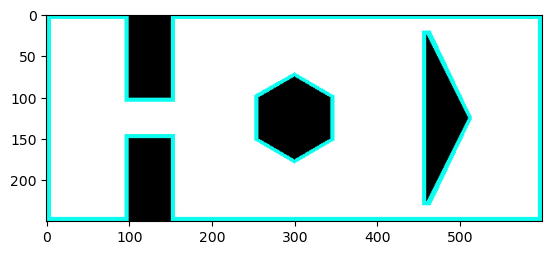

In [11]:

initial_point = [11 ,11, 0]
goal_point = [150, 125, 0]
step_size = 10
robot_clear = 5
object_clear = 5

# Converting initial and final goals to multiple of 30 
init_deg = int(initial_point[2]/30)
goal_deg = int(goal_point[2]/30)
# Converting inputs from list to tuple and integer 
start=(initial_point[1], initial_point[0],init_deg)
goal=(goal_point[1], goal_point[0],goal_deg)
# robot_clear = robot_clear[0]
# object_clear = object_clear[0]
# step_size = step_size[0]

#Creating an instance of A*
d_algo = Astar(600,250,1,start,goal,robot_clear,object_clear,step_size)

# Call the game method
d_algo.game()

In [14]:
def roundn(num):
        if num>=np.floor(num)+0.5:
            rounded_num = np.ceil(num) if 0.75 < (num%1) else num-(num%0.5)
        else:
            rounded_num = np.floor(num)+0.5 if  0.25 < (num%1) else num-(num%0.5)
        return  rounded_num

In [1]:
l=[1,2,3,4,5]

In [2]:
l[-1]

5

import numpy as np
import cv2
grid=np.ones((self.HEIGHT,self.WIDTH,3),np.uint8)
nodes=[]
for i in range(self.HEIGHT):
    for j in  range(self.WIDTH):
            if self.check_robot((i,j)):
                grid[i][j]=np.array(robot_clear_color)
                if self.check_clearance((i,j)):
                    grid[i][j]=np.array(clear_color)
                    if self.check_obstacle((i,j)):
                        grid[i][j]=np.array(obst_color)
            else:
                grid[i][j]=np.array(background)
cv2.imshow("Frame",grid)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# Project 3 
# Submission By: Shantanu Parab (sparab), Vineet Singh (vsingh03)

# GITHUB Link: https://github.com/shantanuparabumd/ASTAR.git

# Imports
import math
import numpy as np
import time
from queue import PriorityQueue
import cv2
import argparse

# Creating Node Class
class Astar:
    def __init__(self,width,height,scale,start,goal,robot_clear,obj_clear,step_size):
        
        # Get the video dimensions and FPS
        self.result = cv2.VideoWriter("Astar01.avi", cv2.VideoWriter_fourcc(*'MJPG'), 600, (width, height))
        
        # Define constants
        self.START=start
        self.GOAL=goal
        self.SCALE=scale
        self.WIDTH=width
        self.HEIGHT=height
        self.L=step_size
        self.frame_info=[]
        self.ROBOT=robot_clear
        self.OBJ=obj_clear

        # Define Colors
        self.background=(255,255,255)
        self.obst_color=(0,0,0)
        self.clear_color= (12, 253, 240)
        self.grid_color=(233, 226, 230, 0.2)
        self.start_color=(132, 222, 15, 0.8)
        self.goal_color=(254, 0, 0, 0.8)
        self.explored_color= (64, 188, 237)
        self.track_color= (16, 141, 16)
        self.robot_color= (62, 169, 119)
        self.robot_clear_color= (255, 255, 255)

        # Define Grid Size
        self.grid_size=2

        self.H_PX=self.WIDTH*self.SCALE/self.grid_size
        self.V_PX=self.HEIGHT*self.SCALE/self.grid_size

        self.HEX=self.hexagon(125,300,50)
        self.HEX_CLR=self.hexagon(125,300,50+(self.OBJ))
        self.HEX_ROBO_CLR=self.hexagon(125,300,50+(self.OBJ+self.ROBOT))
        # Triangle
        p1=(25-self.OBJ, 460-self.OBJ)
        p2=(25-self.OBJ, 460+self.OBJ)
        p3=(125,510+self.OBJ)
        p4=(225+self.OBJ, 460+self.OBJ)
        p5=(225+self.OBJ,460-self.OBJ)
        self.TRI_CLR = [p1, p2, p3, p4, p5]
        
        p1=(25-(self.OBJ+self.ROBOT), 460-(self.OBJ+self.ROBOT))
        p2=(25-(self.OBJ+self.ROBOT), 460+(self.OBJ+self.ROBOT))
        p3=(125,510+(self.OBJ+self.ROBOT))
        p4=(225+(self.OBJ+self.ROBOT), 460+(self.OBJ+self.ROBOT))
        p5=(225+(self.OBJ+self.ROBOT),460-(self.OBJ+self.ROBOT))
        self.TRI_ROBO_CLR = [p1, p2, p3, p4, p5]
        
        p1=(25,460)
        p2=(225, 460)
        p3=(125,510)
        self.TRI=[p1,p2,p3]
    
    def line_equation(self,p,p1,p2):
        try:
            m=(p2[1]-p1[1])/(p2[0]-p1[0])
            value=p[1]-p1[1]-(m*p[0])+(m*p1[0])
        except:
            value=p[0]-p1[0]
            
        return value
    
    def hexagon(self,cx, cy, sl):
            # Calculate the points of the hexagon
            center_x = cx
            center_y = cy
            side_length = sl
            angle_deg = 60
            angle_rad = math.radians(angle_deg)
            angle_deg = 60
            angle_rad = math.radians(angle_deg)
            points = []
            for i in range(6):
                x = round(center_x + side_length * math.cos(angle_rad * i))
                y = round(center_y + side_length * math.sin(angle_rad * i))
                points.append((x, y))
            return points
    
    def obstacle_detect_triangle(self,p,v1,v2,v3):
        h1=self.line_equation(p,v2,v3)>=0 if self.line_equation(v1,v2,v3)>0 else self.line_equation(p,v2,v3)<=0
        h2=self.line_equation(p,v1,v3)>=0 if self.line_equation(v2,v1,v3)>0 else self.line_equation(p,v1,v3)<=0
        h3=self.line_equation(p,v1,v2)>=0 if self.line_equation(v3,v1,v2)>0 else self.line_equation(p,v1,v2)<=0
        print(h1,h2,h3)
        return h1 and h2 and h3

    def obstacle_detect_rectangle(self,point,x,y,width,height):
        if point[0]>=x and point[1]>=y and point[0]<=(x+width) and point[1]<=(y+height):
            return True
        else:
            return False
    
    def obstacle_detect_boundary(self,point,x,y,width,height):
        if point[0]<=x or point[1]<=y or point[0]>=(x+width) or point[1]>=(y+height):
            return True
        else:
            return False
        
    def obstacle_detect_polygon(self,p,points):
        points=points+points[:3]
        for i in range(len(points)-3):
            v1,v2,v3=points[i],points[i+1],points[i+2]
            h=self.line_equation(p,v1,v2)>=0 if self.line_equation(v3,v1,v2)>0 else self.line_equation(p,v1,v2)<=0
            if not h:
                return False
        return True
        
    def check_obstacle(self,p):
        h1=self.obstacle_detect_rectangle(p,0,100,100,50)
        h2=self.obstacle_detect_rectangle(p,150,100,100,50)
        h3=self.obstacle_detect_polygon(p,self.HEX)
        h4=self.obstacle_detect_polygon(p,self.TRI)

        return (h1 or h2 or h3 or h4 )
    
    def check_clearance(self,p):
        h1=self.obstacle_detect_rectangle(p,0,100-self.OBJ,100+self.OBJ,50+2*self.OBJ)
        h2=self.obstacle_detect_rectangle(p,150-self.OBJ,100-self.OBJ,100+self.OBJ,50+2*self.OBJ)
        h3=self.obstacle_detect_polygon(p,self.HEX_CLR)
        h4=self.obstacle_detect_polygon(p,self.TRI_CLR)
        h5= self.obstacle_detect_boundary(p,self.OBJ,self.OBJ,250-2*self.OBJ,600-2*self.OBJ)
        
        return (h1 or h2 or h3 or h4 or h5)
    
    def check_robot(self,p):
        h1=self.obstacle_detect_rectangle(p,0,100-(self.OBJ+self.ROBOT),100+(self.OBJ+self.ROBOT),50+2*(self.OBJ+self.ROBOT))
        h2=self.obstacle_detect_rectangle(p,150-(self.OBJ+self.ROBOT),100-(self.OBJ+self.ROBOT),100+(self.OBJ+self.ROBOT),50+2*(self.OBJ+self.ROBOT))
        h3=self.obstacle_detect_polygon(p,self.HEX_ROBO_CLR)
        h4=self.obstacle_detect_polygon(p,self.TRI_ROBO_CLR)
        h5= self.obstacle_detect_boundary(p,(self.OBJ+self.ROBOT),(self.OBJ+self.ROBOT),250-2*(self.OBJ+self.ROBOT),600-2*(self.OBJ+self.ROBOT))
        
        return (h1 or h2 or h3 or h4 or h5)

    def make_obstacle_space(self):
        grid=np.ones((self.HEIGHT,self.WIDTH,3),np.uint8)
        nodes=[]
        for i in range(self.HEIGHT):
            row=[]
            for j in  range(self.WIDTH):
                theta=[]
                for t in range(361):
                    if self.check_robot((i,j)):
                        theta.append([-1,None,None,None,(i,j,t),None])
                        grid[int(np.floor(i))][int(np.floor(j))]=np.array(self.robot_clear_color)
                        if self.check_clearance((i,j)):
                            grid[int(np.floor(i))][int(np.floor(j))]=np.array(self.clear_color)
                            if self.check_obstacle((i,j)):
                                grid[int(np.floor(i))][int(np.floor(j))]=np.array(self.obst_color)
                    else:
                        theta.append([float('inf'),float('inf'),None,None,(i,j,t),float('inf')])
                        grid[int(np.floor(i))][int(np.floor(j))]=np.array(self.background)
                row.append(theta)
            nodes.append(row)
        return grid,nodes

    def game(self):
        self.running=True
        if self.START[0]>=0 and self.START[0]<self.HEIGHT and self.START[1]>=0 and self.START[1]<self.WIDTH:
            if self.check_clearance(self.START):
                print("Invalid Start")
                self.running=False
            else:
                print("Valid Start")
        else:
            self.running=False
            print(" Start Out of Bounds")

        if self.GOAL[0]>=0 and self.GOAL[0]<self.HEIGHT and self.GOAL[1]>=0 and self.GOAL[1]<self.WIDTH:
            if self.check_clearance(self.GOAL):
                print("Invalid Goal")
                self.running=False
            else:
                print("Valid Goal")
        else:
            self.running=False
            print(" Goal Out of Bounds")
        if self.running:
            start_time = time.time()
            self.img,self.node_grid = self.make_obstacle_space()
            end_time = time.time()
            elapsed_time = end_time - start_time
            print(f"\nGrid formation Time: {elapsed_time:.2f} seconds")
            self.t,self.c= self.astar()
            if self.t is None:
                print("No Path to track")
                return
            self.video()
            self.img=self.back_track(self.t,self.c,self.img)
            for i in range(3000):
                flip_img = cv2.flip(self.img, 0)
                self.result.write(flip_img)
            flip_img = cv2.flip(self.img, 0)
            cv2.imshow("Out", flip_img)
            cv2.waitKey(10)
            cv2.destroyAllWindows()

    def back_track(self,tracker,current,img):
        g_node=current
        path=[]
        while not g_node[3]==0:
            for c in tracker:
                if c[3] == g_node[2]:
                    path.append([c[4][1],c[4][0]])
                    g_node=c
        print("Complete")
        path.reverse()
        for i in range(len(path)-1):
            x1,y1=path[i]
            x2,y2=path[i+1]
            print(path[i],path[i+1])
            # draw the line on the image
            img=cv2.line(img, (int(x2),int(y2)), (int(x1),int(y1)), self.track_color, 4)
        return img
    
    def roundn(self,num):
        if num>=np.floor(num)+0.5:
            rounded_num = np.ceil(num) if 0.75 < (num%1) else num-(num%0.5)
        else:
            rounded_num = np.floor(num) if  0.25 < (num%1) else num-(num%0.5)
        return  rounded_num
    
    def action_set(self,current,action):
        t=0
        r= 0.038
        L= 0.354
        dt=0.1
        xg=current[0]
        yg=current[1]
        thetag=np.deg2rad(current[2])

        D=0
        while t<1:
            t=t+dt
            del_xn += 0.5*r*sum(action)*math.cos(thetag)*dt
            del_yn += 0.5*r*sum(action)*math.sin(thetag)*dt
            thetag+=(r/L)*(action[1]-action[0])*dt
            print(del_xn,del_yn,thetag)
            D=D+math.sqrt(math.pow(0.5*r*sum(action)*math.cos(thetag),2)+math.pow(0.5*r*sum(action)*math.sin(thetag),2))
        thetag=np.rad2deg(thetag)
        if (thetag >360):
            thetag = thetag - 360
        elif (thetag<0):
            thetag = 360+thetag
        else:
            pass
        xg=xg+del_xn
        yg=yg+del_yn
        xg=self.roundn(xg)
        yg=self.roundn(yg)
#       Cost,CostToGoal,ParentID,Id,Location,CostToCome
        if xg>=0 and yg>=0 and xg<self.WIDTH and yg<self.HEIGHT:
                cost=D
                if not self.check_robot((xg,yg)):
                    node=[-1,None,None,None,(xg,yg,thetag),None]
                else:
                    node=[float('inf'),float('inf'),None,None,(xg,yg,thetag),float('inf')]
                return node,cost
        else:
            return None,None
    
    def draw_vector(self,current,neighbor):
        # define the start and end points of the line
        start_point = (int(np.floor(current[4][1])),int(np.floor(current[4][0])))
        end_point = (int(np.floor(neighbor[4][1])),int(np.floor(neighbor[4][0])))

        # draw the line on the image
        self.img=cv2.line(self.img, start_point, end_point, self.robot_color, 1)
        
    def cost_to_goal(self,x,y):
        return math.sqrt((self.GOAL[0]-x)**2 + (self.GOAL[1]-y)**2)
    
    def check_goal(self, current):
        # Calculate the distance between the point and the center of the circle using the Pythagorean theorem
        distance = ((current[0] - self.GOAL[0]) ** 2 + (current[1] - self.GOAL[1]) ** 2) ** 0.5
        # If the distance is less than or equal to the radius of the circle, the point lies within the circle
        if distance <= 1.5:
            return True
        else:
            return False

    def check_dup(self,current, open_list):
        for _,_,_,_,node,_ in open_list:
            if ((current[0] - node[0]) ** 2 + (current[1] - node[1]) ** 2)<=0.5:
                return True
        return False
    
    def video(self):
        for current,neighbor in self.frame_info:
            self.draw_vector(current,neighbor)
            flip_img = cv2.flip(self.img, 0)
            self.result.write(flip_img)
                 
    def astar(self):
        start_time = time.time()
        idx=1
        start_cost_to_goal=math.sqrt((self.GOAL[0]-self.START[0])**2 + (self.GOAL[1]-self.START[1])**2)
        start=(start_cost_to_goal,start_cost_to_goal,0,0,self.START,0)
        goal=(float('inf'),0,None,None,self.GOAL,None)
        
         # Define action sets
        self.L = 10
        actions = [[k, self.L] for k in range(-2,3)]
        
        # Create an open list
        open_list = PriorityQueue()
        # Create a close list
        close_list=[]
        # Create a tracker for path node with compatible data type
        tracker=[]
        current=start
        open_list.put(start)
        while open_list and not self.check_goal(current[4]):
            current=open_list.get()
            close_list.append(current[4])
            tracker.append(current)
            if self.check_goal(current[4]):
                    break
            else:
                for a in actions:
                    neighbor,cost_of_action=self.action_set(current[4],a)
                    if not neighbor==None:
                        
                        if neighbor[4] not in close_list and not neighbor[0]==-1:
                            if  neighbor[0]==float('inf'):
                                self.frame_info.append([current,neighbor])
                                # self.draw_vector(current,neighbor)
                                # flip_img = cv2.flip(self.img, 0)
                                # # cv2.imshow("Out",flip_img)
                                # # cv2.waitKey(1)
                                # # if cv2.waitKey(20) & 0xFF == ord('q'):
                                # #     break
                                # self.result.write(flip_img)
#                                 Parent
                                neighbor[2]=current[3]
#                                 Cost to Come
                                neighbor[5]=current[5]+cost_of_action
#                                 Cost
                                neighbor[0]=neighbor[5]+self.cost_to_goal(neighbor[4][0],neighbor[4][1])
                                neighbor[1]=self.cost_to_goal(neighbor[4][0],neighbor[4][1])
                                idx=idx+1
                                neighbor[3]=idx
                                open_list.put(tuple(neighbor))
#                     Cost,CostToGoal,ParentID,Id,Location,CostToCome
                            else:
                                if neighbor[0]>current[5]+cost_of_action:
                                    neighbor[2]=current[3]
                                    neighbor[5]=current[5]+cost_of_action
                                    neighbor[0]=neighbor[5]+self.cost_to_goal(neighbor[4][0],neighbor[4][1])
        if not open_list:
            print("Goal Not Found")
            return None, None
        
        tracker.append(current)          
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"\nExecution time of algorithm: {elapsed_time:.2f} seconds")
        return tracker,current
    
